In [1]:
import torch

from model import *
from data import *
from vis import *
import gc

import itertools

In [2]:
config = Config().load("config.json")

In [3]:
def itertoolsBetter(dataIter):
    while True:
        for batch in dataIter:
            yield batch


def trainModel(config, modelClass, dataClass, objective, epochs, criterion: dict[str: nn.Module]):
    model = None
    try:
        dataset = dataClass(config)

        dataset.info(dataset[0])

        trainSize = len(dataset)
        # TODO: More stratified subsets using dataset.lengths and geographic information
        train = torch.utils.data.Subset(dataset, range(int(trainSize * config.dataSplit)))
        test = torch.utils.data.Subset(dataset, range(int(trainSize * config.dataSplit), trainSize))

        trainSampler = GraphSizeSampler(train, nodesPerBatch=config.nodesPerBatch, force=False)
        testSampler = GraphSizeSampler(test, nodesPerBatch=config.nodesPerBatch, force=False)

        train = DataLoader(train, batch_sampler=trainSampler, generator=torch.Generator(device))
        test = DataLoader(test, batch_sampler=testSampler, generator=torch.Generator(device))

        dataset.info(next(iter(train)))

        model = modelClass(config)
        print(f"Model has {sum([p.numel() for p in model.parameters()])} parameters")
        print(f"Dataset has {len(dataset)} samples")
        print(next(model.parameters()).is_cuda)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        testIter = itertoolsBetter(test)

        client = Client("127.0.0.1", 12945)

        for epoch in range(epochs):
            progress = 0
            for inputs, targets in train:
                model.train()
                optimizer.zero_grad()

                metrics = {}

                history, future = targets.dischargeHistory, targets.dischargeFuture
                thresholds, deviations = targets.thresholds, targets.deviation.unsqueeze(-1)
                hindcast, forecast = model(inputs)
                loss = objective(forecast, future)

                for eval in criterion:
                    evaluated = criterion[eval](forecast, future, thresholds=thresholds, deviation=deviations)
                    metrics["Train " + eval] = evaluated

                # TODO: Determine source of nans
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"\nNAN FOUND IN LOSS")
                    dataset.info((inputs, targets))
                    print("\n")
                    continue

                trainLoss = loss.detach().item()

                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
                torch.nn.utils.clip_grad_value_(model.parameters(), 10)

                optimizer.step()

                torch.cuda.empty_cache()

                with torch.no_grad():
                    model.eval()
                    inputs1, targets1 = next(testIter)

                    history1, future1 = targets1.dischargeHistory, targets1.dischargeFuture
                    thresholds1, deviations1 = targets1.thresholds, targets1.deviation.unsqueeze(-1)
                    hindcast1, forecast1 = model(inputs1)
                    loss1 = objective(forecast1, future1)
                    testLoss = loss1.detach().item()

                    for eval in criterion:
                        evaluated = criterion[eval](forecast1, future1, thresholds=thresholds1, deviation=deviations1)
                        metrics["Test " + eval] = evaluated

                if (progress + 1) % 10 == 0:
                    gc.collect()

                client.send("Train Loss", trainLoss)
                client.send("Test Loss", testLoss)

                for metric in metrics:
                    client.send(metric, metrics[metric])

                progress += 1

                print(f"\r{progress}/{len(train)} | {(progress / len(train)) * 100:.3f}% |  Train Loss: {trainLoss} | Test Loss: {testLoss} | Memory: {torch.cuda.memory_allocated()}", end="")
            print()

        return model

    except KeyboardInterrupt:
        if model is not None:
            torch.save(model.state_dict(), "checkpoint.pt")
        return model

Loading GeoPandas...
GeoPandas Loaded
2544/2544 GRDC files loaded
9640/9640 ERA5 files loaded
Total empty basins: 37
57622/57646 Basin Structures Appended to Graph
Upstream Basins Compiled | 1.0 | 17.43485477178423
Upstream Structures Compiled
Structure Tensors Complete
Index Mapping Complete
Static Input Scaling Complete

        Total Samples: 29254761
        Era5 History: torch.Size([1, 120, 7]) torch.float32 -1.1682096719741821 20.482315063476562
        Era5 Future: torch.Size([1, 7, 7]) torch.float32 -1.1123478412628174 2.270690441131592 
        Basin Continuous: torch.Size([1, 277]) torch.float32 -0.8782722353935242 4.530961990356445 
        Basin Discrete: torch.Size([1, 10]) torch.int64 3 587 
        Structure: torch.Size([2, 1]) torch.int64 0 0 
        River Continuous: torch.Size([258]) torch.float32 -2.1314620971679688 6.499033451080322 
        River Discrete: torch.Size([14]) torch.int64 0 2 
        Discharge History: torch.Size([120]) torch.float32 -0.0811006724834

MemoryError: 

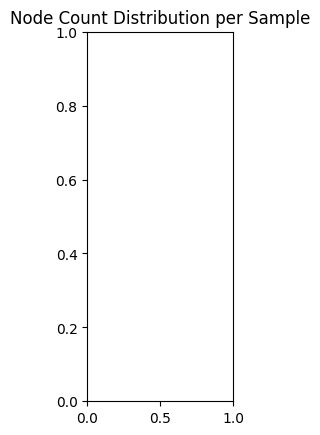

In [4]:
metrics = {
    "NMAE": CMALNormalizedMeanAbsolute(),
    "1 Year Flood Precision": CMALPrecision(),
    "1 Year Flood Recall": CMALRecall()
}

model = trainModel(config, InundationStation, InundationData, CMALLoss(), epochs=10, criterion=metrics)